# Constraint Satisfaction Problems Lab

## Introduction
Constraint Satisfaction is a technique for solving problems by expressing limits on the values of each variable in the solution with mathematical constraints. For example, constraints in [the Sudoku project](https://github.com/ntrang086/sudoku_solver) are enforced implicitly by filtering the legal values for each box, and [the planning project](https://github.com/ntrang086/cargo_planning_search) represents constraints as arcs connecting nodes in the planning graph. In this project we will use [SymPy](http://www.sympy.org/en/index.html), a symbolic math library, to explicitly construct binary constraints and then use Backtracking to solve the N-queens problem (which is a generalization [8-queens problem](https://en.wikipedia.org/wiki/Eight_queens_puzzle)). Using symbolic constraints makes it easier to visualize and reason about the constraints (especially for debugging), but comes with a performance penalty. See the [Sympy_Intro notebook](Sympy_Intro.ipynb) in the same directory for example code on sympy.

![8-queens puzzle solution](EightQueens.gif)

Briefly, the 8-queens problem asks us to place 8 queens on a standard 8x8 chessboard such that none of the queens are in "check" (i.e., no two queens occupy the same row, column, or diagonal). The N-queens problem generalizes the puzzle to to any size square board.

This project consists of three main steps:

* [**Step 1**](#step1): Implement the NQueensCSP class to develop an efficient encoding of the N-queens problem and explicitly generate the constraints bounding the solution
* [**Step 2**](#step2): Implement the search functions for recursive backtracking
* [**Step 3**](#step3): Solve the N-queens problem

The algorithms in this project are based on the [Artificial Intelligence: A Modern Approach](http://aima.cs.berkeley.edu/) (AIMA) book.

First, let's import the libraries needed for the project.

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from util import constraint, displayBoard
from sympy import *
from IPython.display import display
init_printing()
%matplotlib inline
import copy

## Step 1: Representing the N-Queens Problem <a class="anchor" id="step1"></a>
There are many acceptable ways to represent the N-queens problem, but one convenient way is to recognize that one of the constraints (either the row or column constraint) can be enforced implicitly by the encoding.  If we represent a solution as an array with N elements, then each position in the array can represent a column of the board, and the value at each position can represent which row the queen is placed on.

In this encoding, we only need a constraint to make sure that no two queens occupy the same row, and one to make sure that no two queens occupy the same diagonal.

### Define Symbolic Expressions for the Problem Constraints
Before implementing the board class, we need to construct the symbolic constraints that will be used in the CSP.  We will declare three symbolic terms and two generic constraint generators:
- `diffRow` - generate constraints that return True if the two arguments do not match
- `diffDiag` - generate constraints that return True if two arguments are not on the same diagonal

Both generators should produce binary constraints (i.e., each should have two free symbols) once they're bound to specific variables in the CSP. For example, Eq((a + b), (b + c)) is not a binary constraint, but Eq((a + b), (b + c)).subs(b, 1) _is_ a binary constraint because one of the terms has been bound to a constant, so there are only two free variables remaining. 

In [17]:
# Declare symbolic variables for the constraint generators
x1, x2, diff = symbols("x1, x2, diff")

# Define diffRow and diffDiag constraint generators
diffRow = constraint("diffRow", Ne(x1, x2))
diffDiag = constraint("diffDiag", Ne(abs(x1-x2), diff))
print(Ne(x1, x2))

Ne(x1, x2)


In [18]:
# Test diffRow and diffDiag
_x = symbols("x:3")

# Generate a diffRow instance for testing
diffRow_test = diffRow.subs({x1:_x[0], x2:_x[1]})

assert(len(diffRow_test.free_symbols) == 2)
assert(diffRow_test.subs({_x[0]: 0, _x[1]: 1}) == True)
assert(diffRow_test.subs({_x[0]: 0, _x[1]: 0}) == False)
assert(diffRow_test.subs({_x[0]: 0}) != False)  # partial assignment is not false
print("Passed all diffRow tests.")

# Generate a diffDiag instance for testing. We can easily test whether queens in two columns are on
# the same diagonal by testing if the difference in the number of rows and the number of columns match)
diffDiag_test = diffDiag.subs({x1:_x[0], x2:_x[2], diff: 2})

assert(len(diffDiag_test.free_symbols) == 2)
assert(diffDiag_test.subs({_x[0]: 0, _x[2]: 2}) == False)
assert(diffDiag_test.subs({_x[0]: 0, _x[2]: 0}) == True)
assert(diffDiag_test.subs({_x[0]: 0}) != False)  # partial assignment is not false
print("Passed all diffDiag tests.")

Passed all diffRow tests.
Passed all diffDiag tests.


### The N-Queens CSP Class
Implement the CSP class as described above, with constraints to make sure each queen is on a different row and different diagonal from every other queen, and a variable for each column defining the row containing a queen in that column.

In [ ]:
class NQueensCSP:
    """CSP representation of the N-queens problem.
    
    Parameters:
    N: Integer
        The side length of a square chess board to use for the problem, and
        the number of queens that must be placed on the board
    """
    def __init__(self, N):
        # Declare symbolic variables in the CSP constructor"
        _vars = symbols("col:" + str(N))
        _domain = set(range(N))
        self.size = N
        self.variables = _vars
        self.domains = {v: set(_domain) for v in _vars}
        self._constraints = {x: set() for x in _vars}

        # Add constraints - for each pair of variables xi and xj, create
        # a diffRow(xi, xj) and a diffDiag(xi, xj) instance, and add them
        # to the self._constraints dictionary keyed to both xi and xj;
        # (i.e., add them to both self._constraints[xi] and self._constraints[xj])
        for i in range(self.size):
            for j in range(i+1, self.size):
                xi = self.variables[i]
                xj = self.variables[j]
                diffRow_xi_xj = diffRow.subs({x1: xi, x2: xj})
                diffDiag_xi_xj = diffDiag.subs({x1: xi, x2: xj, diff: abs(i - j)})
                self._constraints[xi].add(diffRow_xi_xj)
                self._constraints[xi].add(diffDiag_xi_xj)
                self._constraints[xj].add(diffRow_xi_xj)
                self._constraints[xj].add(diffDiag_xi_xj)
    
    @property
    def constraints(self):
        """Read-only list of constraints -- cannot be used for evaluation."""
        constraints = set()
        for _cons in self._constraints.values():
            constraints |= _cons
        return list(constraints)
    
    def is_complete(self, assignment):
        """An assignment is complete if it is consistent, and all constraints
        are satisfied. Backtracking search checks consistency of each assignment, 
        so checking for completeness can be done very efficiently by only checking 
        if the board has all N queens on it.
        
        Parameters:
        assignment: dict(sympy.Symbol: Integer)
            An assignment of values to variables that have previously been checked
            for consistency with the CSP constraints
        
        Returns:
        True if complete; False otherwise
        """
        return (len(assignment) == self.size)
    
    def is_consistent(self, var, value, assignment):
        """Check consistency of a proposed variable assignment.
        self._constraints[x] returns a set of constraints that involve variable `x`.
        An assignment is consistent unless it causes a constraint to return False 
        (partial assignments are always consistent).
        
        Parameters:
        var: sympy.Symbol
            One of the symbolic variables in the CSP
            
        value: Numeric
            A valid value (i.e., in the domain of) the variable `var` for assignment

        assignment: dict(sympy.Symbol: Integer)
            A dictionary mapping CSP variables to row assignment of each queen
            
        Returns:
        True if consistent; False otherwise
        """
        constraints = self._constraints[var]
        assignment_copy = assignment.copy()
        assignment_copy[var] = value
        for constraint in constraints:
            if not(constraint.subs(assignment_copy)):
                return False
        return True
        
    def inference(self, var, value):
        """Perform logical inference based on proposed variable assignment.
        Check arc consistency for var when it's assigned with value. 
        Returns an empty dictionary by default; returning None signals "failure".
        
        Parameters:
        var: sympy.Symbol
            One of the symbolic variables in the CSP
        
        value: Integer
            A valid value (i.e., in the domain of) the variable `var` for assignment
            
        Returns:
        dict(sympy.Symbol: Integer) or None
            A partial set of values mapped to variables in the CSP based on inferred
            constraints from previous mappings, or None to indicate failure
        """        
        inferences = {}
        # Find all unassigned neighbors of var
        neighbors = set([v for v in self.variables if v != var and len(self.domains[v]) != 1])
        for neighbor in neighbors:
            neighbor_domain = list(self.domains[neighbor])
            # Go through all the values of the neighbor's domain, and remove any value that
            # is not consistent with the assignment {var:value}
            for val in neighbor_domain:
                if not self.is_consistent(neighbor, val, {var:value, neighbor:val}):
                    self.domains[neighbor].remove(val)
            # If the domain is empty, no inference is made and return None
            if len(self.domains[neighbor]) == 0:
                return None
            # If the domain has exactly 1 variable, add it to the inferences
            elif len(self.domains[neighbor]) == 1:
                inferences[neighbor] = list(self.domains[neighbor])[0]
        return inferences
    
    def show(self, assignment):
        """Display a chessboard with queens drawn in the locations specified by an
        assignment.
        
        Parameters:
        assignment: dict(sympy.Symbol: Integer)
            A dictionary mapping CSP variables to row assignment of each queen
            
        """
        locations = [(i, assignment[j]) for i, j in enumerate(self.variables)
                     if assignment.get(j, None) is not None]
        displayBoard(locations, self.size)

## Step 2: Backtracking Search <a class="anchor" id="step2"></a>
Implement the [backtracking search](https://github.com/aimacode/aima-pseudocode/blob/master/md/Backtracking-Search.md) algorithm and helper functions based on the AIMA text.  

In [20]:
def select(csp, assignment):
    """Choose an unassigned variable in a constraint satisfaction problem """
    # Implement minimum-remaining-values heuristic, i.e. choosing the variable 
    # with the fewest "legal" values
    sorted_variables = sorted(csp.domains.items(), key=lambda x: len(x[1]))
    for var_value_pair in sorted_variables:
        if var_value_pair[0] not in assignment:
            return var_value_pair[0]
    return None

def order_values(var, assignment, csp):
    """Select the order of the values in the domain of a variable for checking during search;
    the default is lexicographically.
    """
    return csp.domains[var]

def backtracking_search(csp):
    """Helper function used to initiate backtracking search """
    return backtrack({}, csp)

def backtrack(assignment, csp):
    """Perform backtracking search for a valid assignment to a CSP
    
    Parameters:
    assignment: dict(sympy.Symbol: Integer)
        A partial set of values mapped to variables in the CSP
        
    csp: CSP
        A problem encoded as a CSP. Interface should include csp.variables, csp.domains,
        csp.inference(), csp.is_consistent(), and csp.is_complete().
    
    Returns:
    dict(sympy.Symbol: Integer) or None
        A partial set of values mapped to variables in the CSP, or None to indicate failure
    """
    if csp.is_complete(assignment):
        return assignment
    var = select(csp, assignment)
    
    assignment_copy = assignment.copy()
    domains_copy = copy.deepcopy(csp.domains)
    inferences = {}
    
    for value in order_values(var, assignment, csp):
        if csp.is_consistent(var, value, assignment):
            assignment[var] = value
            # Update the domain for var with value
            csp.domains[var] = {value}
            inferences = csp.inference(var, value)
            if inferences != None:
                for variable in inferences:
                    if csp.is_consistent(variable, inferences[variable],assignment):
                        assignment[variable] = inferences[variable]
                    else: 
                        inferences = None
                        break
            if inferences != None: # e.g., {}, {col2: 1, col3: 2}, etc.
                result = backtrack(assignment, csp)
                if result:
                    return result
        assignment = assignment_copy.copy()
        csp.domains = copy.deepcopy(domains_copy)
    return None

## Step 3: Solve the N-Queens CSP <a class="anchor" id="step2"></a>
With backtracking implemented, now we can use it to solve instances of the problem. We can change `num_queens` to solve boards of other sizes. Boards larger than 12x12 may take some time to solve.

CSP problems have variables, each variable has a domain, and the problem has a list of constraints.
Showing the variables for the N-Queens CSP:


Showing domain for col0:


And showing the constraints for col0:


Solving N-Queens CSP...
Elasped time 0.08138429999962682


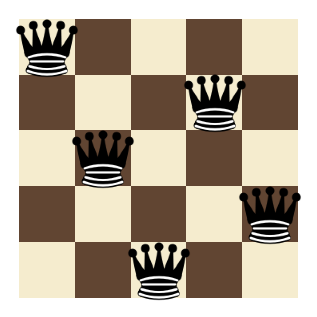

Solution found:
{col0: 0, col1: 2, col2: 4, col3: 1, col4: 3}


In [27]:
import timeit
num_queens = 5
csp = NQueensCSP(num_queens)
var = csp.variables[0]
print("CSP problems have variables, each variable has a domain, and the problem has a list of constraints.")
print("Showing the variables for the N-Queens CSP:")
display(csp.variables)
print("Showing domain for {}:".format(var))
display(csp.domains[var])
print("And showing the constraints for {}:".format(var))
display(csp._constraints[var])

print("Solving N-Queens CSP...")
start_time = timeit.default_timer()
assn = backtracking_search(csp)
elapsed = timeit.default_timer() - start_time
print ("Elasped time", elapsed)
if assn is not None:
    csp.show(assn)
    print("Solution found:\n{!s}".format(assn))
else:
    print("No solution found.")

In [22]:
class MapColoringConstraint(Constraint[str, str]):
     def __init__(self, place1: str, place2: str) -> None:
         super().__init__([place1, place2])
         self.place1: str = place1
         self.place2: str = place2
  
     def satisfied(self, assignment: Dict[str, str]) -> bool:
         # If either place is not in the assignment then it is not
         # yet possible for their colors to be conflicting
         if self.place1 not in assignment or self.place2 not in assignment:
             return True
         # check the color assigned to place1 is not the same as the
         # color assigned to place2
         return assignment[self.place1] != assignment[self.place2]

NameError: name 'Constraint' is not defined

In [ ]:
if __name__ == "__main__":
     variables: List[str] = ["Western Australia", "Northern Territory", "South Australia",
                             "Queensland", "New South Wales", "Victoria", "Tasmania"]
     domains: Dict[str, List[str]] = {}
     for variable in variables:
         domains[variable] = ["red", "green", "blue"]
     csp: CSP[str, str] = CSP(variables, domains)
     csp.add_constraint(MapColoringConstraint("Western Australia", "Northern Territory"))
     csp.add_constraint(MapColoringConstraint("Western Australia", "South Australia"))
     csp.add_constraint(MapColoringConstraint("South Australia", "Northern Territory"))
     csp.add_constraint(MapColoringConstraint("Queensland", "Northern Territory"))
     csp.add_constraint(MapColoringConstraint("Queensland", "South Australia"))
     csp.add_constraint(MapColoringConstraint("Queensland", "New South Wales"))
     csp.add_constraint(MapColoringConstraint("New South Wales", "South Australia"))
     csp.add_constraint(MapColoringConstraint("Victoria", "South Australia"))
     csp.add_constraint(MapColoringConstraint("Victoria", "New South Wales"))
     csp.add_constraint(MapColoringConstraint("Victoria", "Tasmania"))
  